# Introduction to LDI
The liability-driven investing (LDI) paradigm, which is supported by portfolio theory and has now become the accepted approach to asset-liability management, recommends that investors should in general hold a combination of a well-diversified performance-seeking portfolio (PSP), which targets diversification, and a safe liability/goal-hedging portfolio (LHP/GHP), which takes care of hedging. Moreover, the relative weights should be a function of market conditions, as well as strategic objectives and constraints faced by investors.

# Present Value of Liabilities and Funding Ratio
Assuming we use the Zero Coupon Bond as the hedge, then the present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is given by:

This equation can be understood as the value of Zero Coupon Bond I must hold, in order to pay off all the liabilities by their respective due times.
\begin{equation*}
PV(L) = \sum^k_{i=1} B(t_i) L_i
\end{equation*}
where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$.
If we assume the yield curve is flat and the annual rate of interst is $r$ then $B(t)$ is given by
\begin{equation}
B(t) = \frac{1}{(1+r)^t}
\end{equation}

In [3]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time t, given discount interest rate r
    """
    return 1/(1+r)**t

def pv(l, r):
    """
    Computes the present value of a sequence of liabilities
    l is indexed by the time, and the values are the amounts of each liability
    returns the present value of the sequence
    """
    dates = l.index
    discounts = discount(dates, r)
    return discounts.T @ l

In [6]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])
liabilities
# index = years in the future I need to pay, data = amount that I owe

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [7]:
liabilities.sum()
# i.e. I owe 7 million dollars

7.0

In [8]:
pv(liabilities, 0.03)
# If I owe 7 million dollars, and I own 6.23 millions now, with 3% interest rete, I know I can pay it off!

6.233320315080044

## Funding Ratio

In [22]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of some assets given liabilities and interest rate"""
    return assets/pv(liabilities, r)

In [23]:
funding_ratio(5, liabilities, 0.03)
# The funding ratio is less than 1, which means you won't be able to pay the liabilities off!

0.8021407126958778

In [24]:
funding_ratio(5, liabilities, 0.02)
# With a lower interest rate, the funding ratio is even worse

0.7720304366941647

In [25]:
funding_ratio(5, liabilities, 0.1)

1.0373579595689422

In [26]:
def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print(f"{fr*100:.2f}%")

controls = widgets.interact(show_funding_ratio,
                assets = widgets.IntSlider(min=1, max=10, step=1, value=5),
                r = (0, 0.2, 0.01)
                )
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

<function __main__.show_funding_ratio(assets, r)>

# CIR Model to simulate changes in Interest Rates and Liability Hedging
The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rates. This model describes the interest rate gravitates to long term mean b with mean reversion speed a, and introduces fluctuations as brownian motion.
\begin{equation*}
dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t
\end{equation*}
where $\sqrt{r_t}$ is the term that prevents negative interest rate - as $r_t$ goes to zero, the brownian motion term goes to zero. The interest rate used here is the Short Rate rather than the Annualized rate.

## Short Rate vs Annualized Rate

If we compound N times a year with annual interest rate r, we get:
$$
(1+\frac{r}{N})^{N}
$$

### Instantaneous interest rate
And as N gets very large, this series converges to $e$.

## $$\lim_{N \to \infty} (1+\frac{r}{N})^{Nt} = e^{rt}$$

for one year

## $$1+r_{ann} = e^{r_{inst}}$$

## $$r_{ann} = e^{r_{inst}}-1$$

## $$r_{inst} = ln(1+r_{ann})$$

In [27]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

def inst_to_ann(r):
    """
    Converts short rate to ann rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert ann to a short rate
    """
    return np.log1p(r)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting the interest rate simulation
\begin{equation*}
dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t
\end{equation*}

In [30]:
def cir(n_years=10, n_scenarios=1, a=0.04, b=0.03, vol=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    r_0 is the initial annual rate, which we converted to instantanous/short rate
    b is the baseline interst rate
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year) + 1
    shock = np.random.normal(loc=0, scale=vol*np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    for step in range(1, num_steps):
        r_t = rates[step-1]
        dr_t = a*(b-r_t)*dt + np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + dr_t)
    
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

In [31]:
def show_cir(r_0=0.03, a=0.5, b=0.03, vol=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, vol=vol, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,6))
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interact(show_cir,
                           a=(0, 1, 0.1),
                           b=(0, 0.15, 0.01),
                           vol=(0, 0.1, 0.01),
                           r_0=(0, 0.1, 0.01),
                           n_scenarios=(1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.1, step=0.01), FloatSlider(value=0.5, d…

<function __main__.show_cir(r_0=0.03, a=0.5, b=0.03, vol=0.05, n_scenarios=5)>

## Generating the random price evolution of a Zero-Coupon Bond

The CIR interest model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations: 

T is the maturaty time, t is the current time.

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [34]:
def cir(n_years=10, n_scenarios=2, a=0.04, b=0.03, vol=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    r_0 is the initial annual rate, which we converted to instantanous/short rate
    b is the baseline interst rate
    returns rate per steps per year (monthly rate if 12 steps), and bond prices
    """
    # first generate the interst rates using CIR model
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)    
    num_steps = int(n_years*steps_per_year) + 1
    dt = 1/steps_per_year
    shock = np.random.normal(loc=0, scale=vol*np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        dr_t = a*(b-r_t)*dt + np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + dr_t)
    
    # Second Calculate Bond prices using the interest rates
    def bond_price():
        h = np.sqrt(a**2 + 2*vol**2)
        tau = n_years - np.linspace(0, n_years, num_steps)
        tau = np.array([tau])
        A = (2*h*np.exp((a+h)*tau/2)/(2*h + (a+h)*np.expm1(tau*h)))**(2*a*b/vol**2)
        B = 2*np.expm1(tau*h)/(2*h + (a+h)*np.expm1(tau*h))
        return A.T*np.exp(-B.T*rates)
    
    P = bond_price()
    
    #Convert to rates per steps_per_year (if 12 steps, then monthly rate)
    rates = (inst_to_ann(rates)+1)**(1/steps_per_year)-1 
    rates = pd.DataFrame(data=rates, index=range(num_steps))
    bond_prices = pd.DataFrame(data=P, index=range(num_steps))

    return rates, bond_prices

In [35]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, vol=0.05, n_scenarios=5):
    _, bond_prices = cir(r_0=r_0, a=a, b=b, vol=vol, n_scenarios=n_scenarios)
    bond_prices.plot(legend=False, figsize=(12,6), title="Bond Prices")
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interact(show_cir_prices,
                           a=(0, 1, 0.1),
                           b=(0, 0.15, 0.01),
                           vol=(0, 0.1, 0.01),
                           r_0=(0, 0.1, 0.01),
                           n_scenarios=(1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.1, step=0.01), FloatSlider(value=0.5, d…

<function __main__.show_cir_prices(r_0=0.03, a=0.5, b=0.03, vol=0.05, n_scenarios=5)>

## Funding Ratio - Cash vs Zero Coupon Bonds
We can if we only hold cash, about 50% of the time the asset value fall below 1 million! You wouldn't be able to pay off your liabilities.
On the other hand, if we only held zero coupon bonds, it always pays 1 million after 10 years. You would pay off your liabilities 100%.

In [39]:
bond_prices

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143,...,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143,0.750143
1,0.749900,0.771501,0.788329,0.766709,0.734553,0.735009,0.753442,0.768577,0.758899,0.773262,...,0.762621,0.737489,0.734392,0.774838,0.747950,0.764989,0.760251,0.734747,0.771322,0.769470
2,0.757110,0.795619,0.773465,0.770365,0.750145,0.734365,0.753528,0.762090,0.749030,0.753637,...,0.756847,0.734491,0.729861,0.783416,0.741518,0.745156,0.726967,0.725749,0.760236,0.772493
3,0.736527,0.795236,0.778329,0.765325,0.728270,0.716298,0.770795,0.763709,0.748145,0.758078,...,0.764723,0.732647,0.717973,0.777651,0.757973,0.754172,0.743897,0.714326,0.775129,0.785515
4,0.744531,0.810382,0.788932,0.737172,0.723055,0.710167,0.783831,0.775540,0.739814,0.765168,...,0.767556,0.735061,0.711259,0.783759,0.765245,0.752294,0.763257,0.716704,0.770302,0.806613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.981474,0.996091,0.994694,0.991623,0.985824,0.973270,0.984866,0.988325,0.996017,0.991518,...,0.985280,0.993746,0.987747,0.987711,0.995032,0.983311,0.982427,0.991636,0.990934,0.988636
117,0.986339,0.997115,0.995556,0.994783,0.989566,0.980876,0.988251,0.991607,0.996831,0.993493,...,0.987897,0.995000,0.991019,0.990971,0.995996,0.988228,0.987593,0.993247,0.993992,0.991231
118,0.991571,0.998094,0.997292,0.996942,0.992520,0.987928,0.992097,0.994636,0.997954,0.996367,...,0.991053,0.996431,0.993770,0.993372,0.997369,0.992044,0.992227,0.996172,0.996024,0.994069
119,0.995724,0.999065,0.998785,0.998106,0.996578,0.993530,0.996111,0.997293,0.998782,0.997867,...,0.995926,0.998386,0.996778,0.996639,0.998908,0.995893,0.996579,0.997743,0.997848,0.996669


In [36]:
a_0 = 0.75 # i.e. my current asset is 75% of the total liabilities
n_scenarios=1000
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=n_scenarios)
"""For simplicity, model present value of liabilities as the bond prices. Because to pay off 1 million in 10 years, 
I would need to hold 1 million bonds that matures to 1 dollar in 10 years"""
liabilities = bond_prices
# How many zero coupon bonds can I buy given 0.75 million dollars?
zc_0 = bond_prices.iloc[0,0] # current zero coupon prices given maturity of 10 years and ann rate 0.03
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices # account value over 10 years if only hold bonds
av_cash = a_0*(1+rates).cumprod() # account value over 10 years if only holds cash

av_cash_terminal = av_cash.iloc[-1]
av_cash_terminal_mean = av_cash_terminal.mean()
av_cash_terminal_short_mean = av_cash_terminal[av_cash_terminal<1].mean()
av_cash_terminal_short_percent = (av_cash_terminal<1).sum()/n_scenarios*100

av_zc_bonds_terminal = av_zc_bonds.iloc[-1]
av_zc_bonds_terminal_mean = av_zc_bonds_terminal.mean()
av_zc_bonds_terminal_short_mean = av_zc_bonds_terminal[av_zc_bonds_terminal<1].mean()
av_zc_bonds_terminal_short_percent = (av_zc_bonds_terminal<1).sum()/n_scenarios*100

For cash: 1.0232374220121643 0.9149254373695224 52.900000000000006
For Zero Coupon Bonds: 0.999808799500329 0.999808799500329 100.0


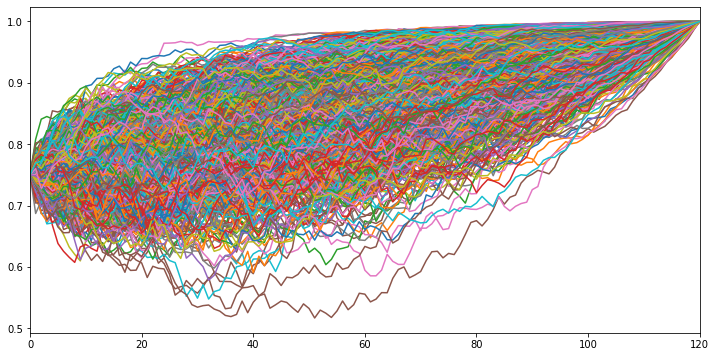

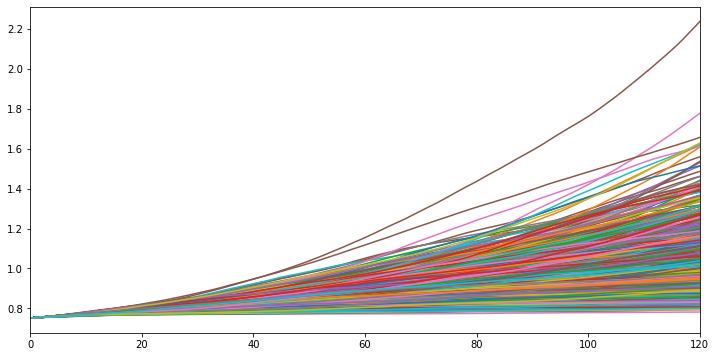

In [37]:
av_zc_bonds.plot(legend=False, figsize=(12,6))
av_cash.plot(legend=False, figsize=(12,6))
print("For cash:", av_cash_terminal_mean, av_cash_terminal_short_mean, av_cash_terminal_short_percent)
print("For Zero Coupon Bonds:", av_zc_bonds_terminal_mean, av_zc_bonds_terminal_short_mean, av_zc_bonds_terminal_short_percent)

### Funding Ratio if only hold Cash
- Remember the Funding Ratio is the Asset to Present Value ratio
- So what happens to your funding ratio if you only hold cash, and you have 1 million liabilities to pay off in 10 years?
- We see that if we only hold cash, it is very risky in terms of future liabilities

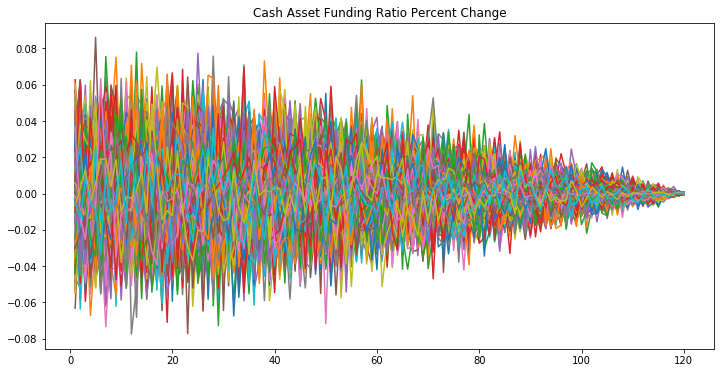

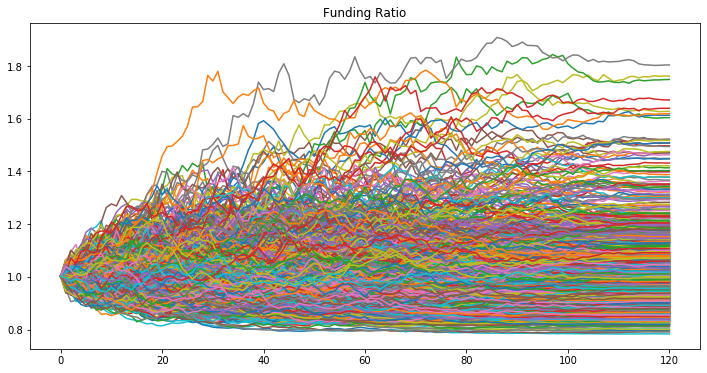

In [21]:
funding_ratio = av_cash/liabilities
funding_ratio.pct_change().plot(legend=False, title="Cash Asset Funding Ratio Percent Change", figsize=(12,6))
funding_ratio.plot(legend=False, title="Funding Ratio", figsize=(12,6))

### Funding Ratio if hold Zero Coupon Bonds
- What if you only hold Zero Coupon Bonds?
- The funding ratio is always 1!! However in real life, it is not easy to buy the exactly liability matching set of bonds.

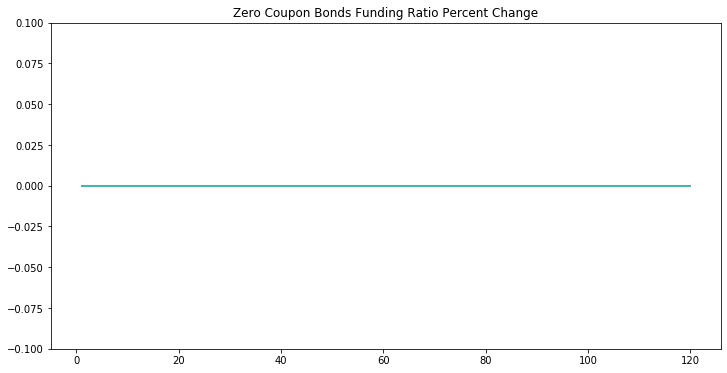

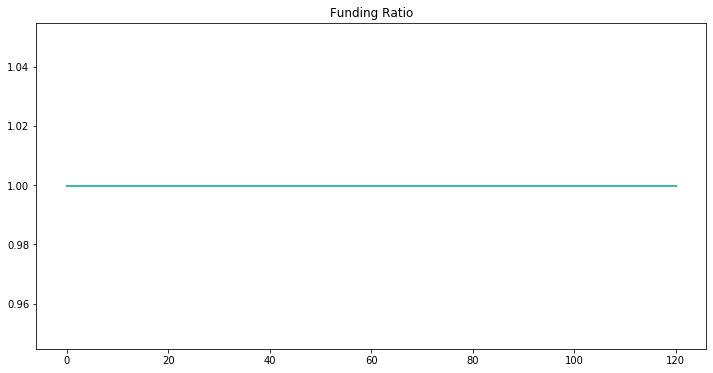

In [22]:
funding_ratio = av_zc_bonds/liabilities
funding_ratio.pct_change().plot(legend=False, title="Zero Coupon Bonds Funding Ratio Percent Change", figsize=(12,6), ylim=(-0.1,0.1))
funding_ratio.plot(legend=False, title="Funding Ratio", figsize=(12,6))

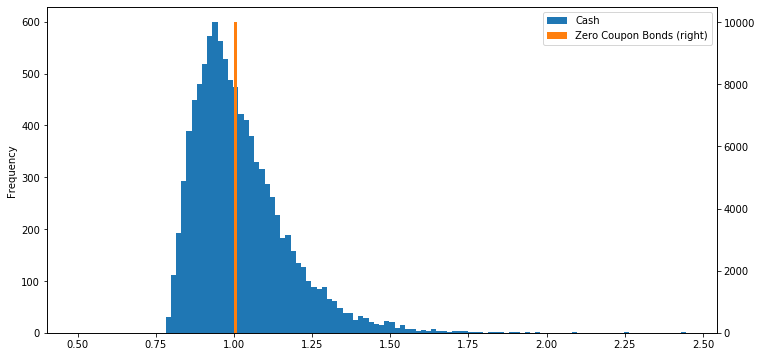

In [23]:
a_0 = 0.75 # i.e. my current asset is 75% of the total liabilities
n_scenarios=10000
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=n_scenarios)
"""For simplicity, model bond prices as the liabilities. Because to pay off 1 million in 10 years, I would need to hold 1 million bonds that matures to 1 dollar in 10 years"""
liabilities = bond_prices
# How many zero coupon bonds can I buy given 0.75 million dollars?
#zc_0 = erk.pv(pd.DataFrame(data=[1], index=[10]), r=0.03) Inconsistent
zc_0 = bond_prices.iloc[0,0] #current zero coupon prices given maturity of 10 years and ann rate 0.03
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices # account value over 10 years if only hold bonds
av_cash = a_0*(1+rates).cumprod() # account value over 10 years if only holds cash

"""Terminal funding ratio - tfr"""
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label="Zero Coupon Bonds", bins=100, legend=True, secondary_y=True)

# GHP Construction with Duration Matching - Macaulay Duration
GHP - Goal Hedging Portfolio


## Hedging = Cash-Flow Matching
___Liability-Hedging Portfolios (LHP)___ or ___Goal-Hedging Portfolios (GHP)___ are portfolios with payoffs matching the dates and nominal amount of liability/goal payments

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Zero Coupon Bonds is more advantageous compared to cash when it comes to liability hedging, however in real life it is not always easy to find ZC bonds that matches the liabilty exatly. However we can reap the benefits similar to ZC bonds by holding a portfolio of regualr coupon-paying bonds as long as we can do factor matching or duration matching.

In [3]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    Return a series of cash flows generated by a bond, indexed by a coupon number
    The coupons_per_year is the number of times coupon is paid per year. i.e. if coupons_per_year = 12, you get paid 12 times a year
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupon_times = np.arange(1, n_coupons+1) # returns np.array([1,2,3,...,n_coupons])
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal # the principal is paid back at the end
    return cash_flows

def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Price a bond based on bond parameters maturity, principal, coupon rate and coupons per year
    and the prevailing discount rate
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)

## Problem of Regular Bonds

In [4]:
"""
If the coupon rate is higher than the interest rate 0.05>0.04, then you will be paying a premium for the bond! 
This is because you are "beating the market" with this coupon rate
"""
erk.bond_price(20, 1000, 0.05, 2, 0.04)

1136.7773962036904

In [5]:
"""
If the coupon rate is the same as interest rate, then the bond price is the same as the principal.
This is because, well, they have the same interest rate :)
"""
erk.bond_price(20, 1000, 0.05, 2, 0.05)

1000.0000000000023

In [6]:
"""
If the coupon rate is lower than the interest rate, then you are at a disadvantage.
Thus lower price.
"""
erk.bond_price(20, 1000, 0.05, 2, 0.06)

884.4261401289671

This explains why when the central banks lowers interest rates, the bond prices increases. Investors will ride this trend to buy bonds, in the process this will further increase the bond price, this drives the bonds coupon rate down until it is the same as the interest rate, reaching equilibrium.

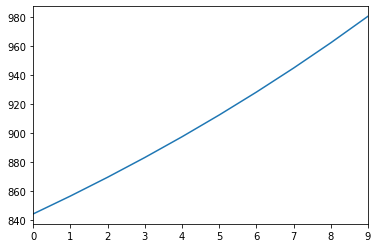

In [28]:
timeframe =np.arange(10,0,-1)
pd.Series(data=timeframe).apply(func=erk.bond_price, principal=1000, coupon_rate=0.03, coupons_per_year=2, discount_rate=0.05).plot()

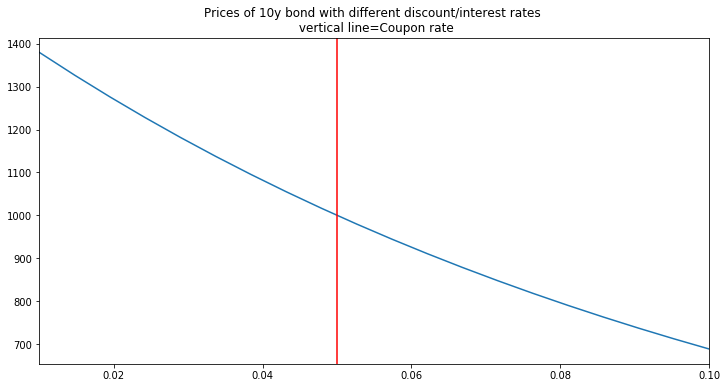

In [31]:
rates = np.linspace(0.01, 0.1, 20)
prices = erk.bond_price(10, 1000, 0.05, 2, rates)
prices = pd.Series(data=prices, index=rates)
ax = prices.plot(figsize=(12,6), title="Prices of 10y bond with different discount/interest rates \n vertical line=Coupon rate")
ax.axvline(x=0.05, color="r")

Therefore this particular 10 year bond is not a good hedge, because if interest rate goes up, the price of the bond falls.

## Macaulay Duration

In [31]:
cf = erk.bond_cash_flows(3, 1000, 0.06, 2)
discounts = erk.discount(cf.index, 0.06/2)
discounts

1    0.970874
2    0.942596
3    0.915142
4    0.888487
5    0.862609
6    0.837484
dtype: float64

In [32]:
dcf = discounts*cf
dcf.sum() # when coupon rate = interest rate, the bond price is always the principal

999.9999999999999

In [33]:
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [34]:
sum(cf.index*weights)

5.579707187194534

In [38]:
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows
    """
    discounted_flows = erk.discount(flows.index, discount_rate) * flows
    weights = discounted_flows/discounted_flows.sum()
    return weights.T @ flows.index

In [80]:
maturity=3; principal=1000; coupon_rate=0.06; coupons_per_year=2; discount_rate = 0.06

flows = erk.bond_cash_flows(maturity=maturity, principal=principal, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year)
erk.macaulay_duration(flows, discount_rate/coupons_per_year)

5.579707187194534

## Duration Matching

Suppose we have two bonds with Macaulay Duration, then the total duration is

$$\omega_s \times d_s + (1-\omega_s)\times d_l = d_t$$

where s = short, l = long, t = target, and $d$ is the Macaulay duration and $\omega$ is the weight.

Rearranging gives:
$$\omega_s = \frac{d_l-d_t}{d_l-d_s}$$

In [81]:
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective duration that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)    
    return (d_l - d_t)/(d_l - d_s)

In [82]:
"""Liability Macaulay Duration"""
liabilities = pd.Series(data=[100000,100000],index=[10,12])
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

In [91]:
cf_short = erk.bond_cash_flows(10, 1000, 0.05, 1)
cf_long = erk.bond_cash_flows(20, 1000, 0.05, 1)

In [92]:
w_s = match_durations(liabilities, cf_short, cf_long, 0.04)
w_s

0.4826309206947901

This means that I must put 48% of my asset into short bond and 52% into long bond in order to pay off my liabilities in macaulay duration of 10.96 years.


In [123]:
price_short = erk.bond_price(10, 1000, 0.05, 1, 0.04)
price_long = erk.bond_price(20, 1000, 0.05, 1, 0.04)
a_0 = 130000 # total initial asset
cf_duration_matching = pd.concat([w_s*a_0/price_short*cf_short, (1-w_s)*a_0/price_long*cf_long])
erk.macaulay_duration(cf_duration_matching, 0.04)

10.96079938508839

We see that the Macaulay duraction of the combination of short and long bonds matches that of the liabilities

In [124]:
erk.funding_ratio(cf_duration_matching, liabilities, 0.04)

0.9998760012192479

We see that the funding ratio is very close to 1, we are pretty much funded.

In [125]:
discount_rates = np.linspace(0, 0.1, 20)
short_bond_assets = a_0/price_long*cf_long
long_bond_assets = a_0/price_short*cf_short
# funding ratio change
fr_change = pd.DataFrame({
    "Long Bonds": [erk.funding_ratio(short_bond_assets, liabilities, rate) for rate in discount_rates],
    "Short Bonds": [erk.funding_ratio(long_bond_assets, liabilities, rate) for rate in discount_rates],
    "Duration Matched Bonds": [erk.funding_ratio(cf_duration_matching, liabilities, rate) for rate in discount_rates]},
    index = discount_rates)

Text(0, 0.5, 'Funding Ratio')

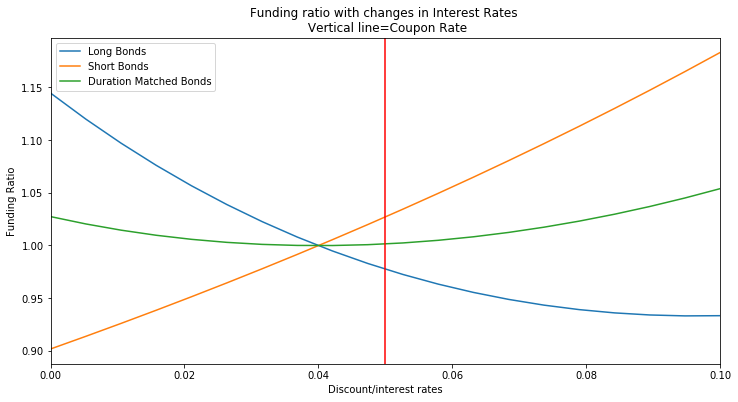

In [126]:
ax = fr_change.plot(title="Funding ratio with changes in Interest Rates \n Vertical line=Coupon Rate", figsize=(12,6))
ax.axvline(0.05, color="r")
plt.xlabel("Discount/interest rates")
plt.ylabel("Funding Ratio")

Notice when discount rate = coupon rate, the funding ratio for all three portfolios are 1. This is because in this special case present value always equal to principal regardless of maturity.


# Optimal Asset Mix


The liability-driven investing strategy suggest that when facing liabilities, we should hold two portfolios: the performance seeking portfolio, which objective is to achieve the most efficient harvesting of risk premia; and the liability hedging portfolio, which objective is to replicate as carefully as possible the effect on exposures in the liabilities stream.

#### Risk Aversion Parameter
Thus how do we define the optimal mix of PSP and LHP for a given investor?  This mix ratio should be defined by the Risk Aversion Parameter, which we call gamma $\gamma$.

- Risk-Aversion Parameter should be thought of as a free parameter.
- In practice, increase the allocation to PSP until risk budget is exhausted.
- Risk budgets is set by the stakeholders or agents acting on their behalf.

<img src="images/Optimal portfolio mix.PNG" style="width: 800px">

# Simulation of Prices of Coupon-Bearing Bonds using CIR

In [74]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Time series interest rate and bond price

In [141]:
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    If discount_rate is a DataFrame, then this is assumed to be the rate on each coupon date
    and the bond value is computed over time.
    i.e. The index of the discount_rate DataFrame is assumed to be the coupon number
    """
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year, principal, coupon_rate, coupons_per_year, discount_rate.loc[t])
        return prices
    else: # base case ... single time period
        if maturity <= 0: return principal+principal*coupon_rate/coupons_per_year
        cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
        return pv(cash_flows, discount_rate/coupons_per_year)

In [240]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)

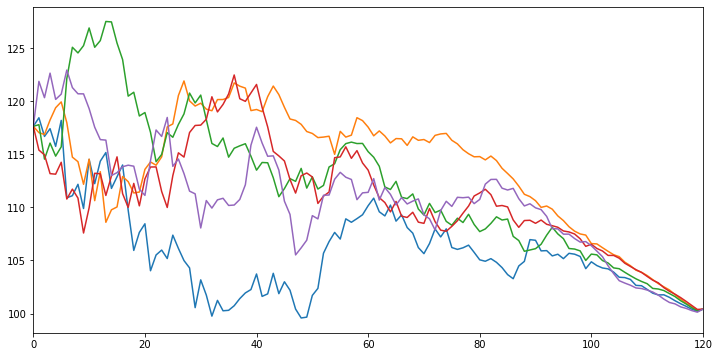

In [241]:
erk.bond_price(10, 100, 0.05, 12, discount_rates).plot(legend=False, figsize=(12,6))

## Bond total return asssuming reinvesting all returns from coupon into bonds
Notice bond prices changes over time due to changes in interest rates, this affects the returns overtime as we reinvests in bonds

In [255]:
def bond_total_return(monthly_prices, principal, coupon_rate, coupons_per_year):
    """
    Computes the total return of a Bond based on monthly bond prices and coupon payments
    Assumes that dividends (coupons) are paid out at the end of the period (e.g. end of 3 months for quarterly div)
    and that dividends are reinvestd in the bond
    """
    
    coupons = pd.DataFrame(data = 0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()

In [256]:
monthly_prices = erk.bond_price(10, 100, 0.05, 12, rates[[0,1,2,3,4]])
btr = erk.bond_total_return(monthly_prices, 100, 0.05, 12)
erk.ann_return(btr)

0    0.028816
1    0.030294
2    0.028245
3    0.028386
4    0.028096
dtype: float64

## Constructing a simple 60/40, 10 year/30 year mix bond portfolio

In [253]:
price_10 = erk.bond_price(10, 100, 0.05, 12, rates)
price_10

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,117.644,117.644,117.644,117.644,117.644,117.644,117.644,117.644,117.644,117.644,...,117.644,117.644,117.644,117.644,117.644,117.644,117.644,117.644,117.644,117.644
1,116.051,117.187,121.357,118.116,116.715,116.908,112.667,115.9,117.169,117.624,...,117.579,117.897,117.512,116.124,115.042,114.618,119.207,117.346,117.656,120.637
2,112.748,112.758,121.914,115.611,116.966,116.889,112.703,115.042,115.685,116.444,...,117.613,118.615,115.856,114.792,117.375,116.197,117.35,116.475,115.235,121.55
3,111.775,112.913,120.228,115.201,117.064,114.06,114.023,113.339,117.588,117.17,...,116.955,117.347,119.844,115.298,118.862,120.047,120.042,115.506,117.344,121.331
4,114.538,115.055,123.941,113.762,115.887,109.031,108.668,113.885,119.975,113.581,...,115.853,120.103,121.856,114.064,120.294,121.942,116.298,114.083,116.845,118.312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,100.63,101.122,101.238,101.604,101.146,100.174,100.808,100.706,99.1217,101.053,...,99.6806,99.1574,100.836,100.477,101.049,101.452,100.071,101.437,100.732,101.367
117,100.514,100.917,100.879,101.215,100.888,100.09,100.684,100.52,99.5098,100.804,...,99.7763,99.5313,100.681,100.322,100.857,101.138,100.061,101.07,100.62,101.039
118,100.36,100.62,100.576,100.815,100.558,100.079,100.466,100.325,99.6085,100.546,...,99.8777,99.7492,100.534,100.138,100.572,100.752,100.064,100.74,100.359,100.693
119,100.196,100.316,100.274,100.405,100.279,100.057,100.254,100.135,99.862,100.288,...,99.966,99.857,100.276,100.086,100.284,100.379,100.052,100.375,100.167,100.341


We see that the price of the bond converges to 100 after 10 years for 10 year bond.

In [252]:
price_30 = erk.bond_price(30, 100, 0.05, 12, rates)
price_30

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,140.541,140.541,140.541,140.541,140.541,140.541,140.541,140.541,140.541,140.541,...,140.541,140.541,140.541,140.541,140.541,140.541,140.541,140.541,140.541,140.541
1,136.621,139.596,150.983,142.069,138.354,138.86,128.074,136.23,139.55,140.756,...,140.635,141.484,140.457,136.812,134.024,132.946,145.019,140.016,140.84,148.965
2,128.451,128.476,152.928,135.715,139.27,139.067,128.338,134.244,135.907,137.892,...,140.997,143.704,136.352,133.601,140.36,137.244,140.294,137.973,134.742,151.888
3,126.222,129.045,148.49,134.881,139.795,131.942,131.848,130.115,141.206,140.081,...,139.503,140.555,147.411,135.133,144.681,147.979,147.965,135.676,140.548,151.623
4,133.385,134.73,159.696,131.387,136.918,119.754,118.9,131.702,148.112,130.925,...,136.829,148.474,153.517,132.162,149.017,153.767,138.012,132.211,139.476,143.469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,128.648,158.465,166.63,196.081,160.119,107.018,138.599,132.791,72.4859,153.809,...,88.5917,73.3885,140.25,120.825,153.518,183.147,102.807,181.924,134.264,176.396
117,131.523,165.256,161.64,197.07,162.524,104.773,144.644,131.933,78.5315,154.804,...,89.3398,79.3319,144.344,118.456,159.582,188.222,103.193,180.771,139.537,177.487
118,133.279,166.177,159.964,197.516,157.52,106.323,145.693,129.442,75.1457,155.967,...,91.1829,82.9965,154.328,111.307,159.506,186.761,105.063,184.757,133.159,177.227
119,136.726,167.568,155.993,196.105,157.294,109.281,150.594,123.619,81.5925,159.673,...,94.9889,81.0164,156.572,114.272,158.552,187.233,108.381,186.117,130.301,175.257


However for 30 years bond we see that the price fluctuates significantly at the end of 10 years. Therefore it is not a good idea to use long bond as hedge, because price do not converge in due time!

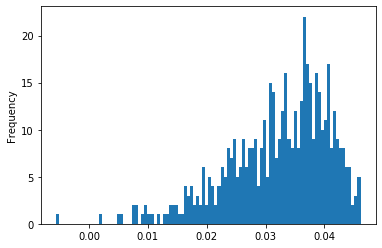

In [257]:
"""Assuming a 60/40 mix between 10 year and 30 years bond, what is the total return?"""
"""This exercise assumes we are rebalancing every month to get a 60/40 ratio, 
because otherwise different returns between long and short bonds would off balance the mix ratio"""
rets_10 = erk.bond_total_return(price_10, 100, 0.05, 12)
rets_30 = erk.bond_total_return(price_30, 100, 0.05, 12)
rets_bond = 0.6*rets_10 + 0.4*rets_30
erk.ann_return(rets_bond).plot.hist(bins=100)

In [258]:
mean_rets_bonds = rets_bond.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Sharpe Ratio,Max Drawdown
0,0.035175,0.002906,0.315133,3.217443,-0.001591,-0.001305,1.733159,0.0


## Constructing Stock Porfolio

In [259]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
price_eq.shape

(121, 500)

In [260]:
rets_eq = price_eq.pct_change().dropna()

## Constructing 70/30 Stock Bond Mix

In [261]:
rets = 0.7*rets_eq + 0.3*rets_bond
rets_mean = rets.mean(axis="columns")
erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Sharpe Ratio,Max Drawdown
0,0.056491,0.004897,-0.260932,2.928142,-0.002171,-0.001442,5.265352,0.0


# Beyond Liability-Hedging Portfolio

The LDI paradigm suggests that investor welfare should depend on how good each building block is at delivering what it's been designed for:
- Portformance seeking portfolio that efficiently harvests risk premia
- Liability hedging portfolio with a good ability to hedge the liability
Intuitively, the interaction between performance and hedging motives is also expected to play an important role.


## Funding Interaction Theorem

### Decomposition of Investor Welfare

### $$IW = \frac{\lambda^2_{PSP}}{2\gamma} + \frac{(1-\gamma)^2}{2\gamma}\sigma^2_L \rho_{L, LHP}^2 + (1-\frac{1}{\gamma})\sigma_L\sigma_{L,PSP}\lambda_{PSP}$$

- 1st term: Pure performance contribution
- 2nd term: Pure hedging contribution
- 3rd term: Cross-contribution performance/hedging
- $\rho$ is the correlation, $\sigma$ volativity, $\lambda$ Sharpe ratio, $\gamma$ risk aversion parameter

### Notice when $\gamma$ tends to infinity, pure performance contribution vanishes. Conversely, when $\gamma$ goes to zero, pure hedging contribution vanishes.

## Fund Seperation/Interaction in Practice

Strong benefits can be expected from improving hedging (respect to performance) characteristics of the PSP (resp.. LLHP): i.e. $\rho_{L,PSP}$

Unless this improvement is associated with an exceedingly large opportunity cost in risk-adjusted performance (resp.. hedging properties): i.e. $\lambda_{PSP}$

Therefore the net investor welfare depends on a trade-off between two competing effects.

For example:
Adopting a more defensive equity benchmark would lead to a decrease in funding ratio volatility, which in turns would allow for an increase in equity allocation for the same risk budget, but it would also lead to a decrease in performance. The impact on investor welfare will be negative if the decrease in performance will more than compensate for the increase in equity exposure.  in performance. The impact on investor welfare will be positive if the increase in equity exposure will more than compensate for the decrease in performance.  


## Trade-off between two competing effects
<img src="images/Trade-off between two competing effects.PNG" style="width: 600px">

### Therefore while diversification and hedging are two rather distinct goals substantial value can be added by aligning PSPs and LHPs.

# Naive Risk Budgeting Strategies between the PSP and GHP
Performance 

In [1]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%load_ext autoreload
%autoreload 2

In [262]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames of returns where T is the time step index and N is the nmber of scenarios
    allocator is a function that takes two sets of returns and allocate specific parameters, and produces
    an allocation to the first portfoio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfoio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be the same shape")    
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights that dont match f1") 
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that :
    - each column is a scenario
    - each row is the price for a timestep
    Retruns an T x N DataFrame of PSP weights
    """
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [263]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)
price_10 = erk.bond_price(10, 100, 0.05, 12, rates)
price_30 = erk.bond_price(30, 100, 0.05, 12, rates)
rets_10 = erk.bond_total_return(price_10, 100, 0.05, 12)
rets_30 = erk.bond_total_return(price_30, 100, 0.05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=0.6)

In [264]:
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds)) 

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Sharpe Ratio,Max Drawdown
0,0.035719,0.003728,0.325961,3.450744,-0.001278,-0.000952,1.492865,0.0


In [266]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [269]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)

summaries = erk.summary_stats(rets_7030b)

In [270]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Sharpe Ratio,Max Drawdown
0,0.069398,0.114416,0.001451,2.617300,0.048196,0.061375,0.335002,-0.149119
1,0.056935,0.091524,-0.181593,3.076149,0.039607,0.050900,0.286323,-0.141516
2,0.041908,0.100333,0.113247,2.530964,0.042939,0.049578,0.115390,-0.268230
3,0.094738,0.104809,0.083329,2.956312,0.040846,0.054919,0.601068,-0.150413
4,0.061280,0.116846,0.263283,3.912380,0.046547,0.066460,0.260414,-0.234433


In [271]:
summaries.mean()

Annualized Return          0.055960
Annualized Vol             0.107312
Skewness                  -0.000256
Kurtosis                   2.956109
Cornish-Fisher VaR (5%)    0.045761
Historic CVaR              0.057975
Sharpe Ratio               0.237469
Max Drawdown              -0.205967
dtype: float64

In [272]:
def terminal_values(rets):
    """
    Returns the final compounded return for each scenarios
    """
    return (1+rets).prod()

def terminal_stats(rets, floor = 0.8, goal=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume reys is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name
    """
    terminal_wealth = (1+rets).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= goal
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = reach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor - terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (terminal_wealth[reach]-goal).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std": terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short": e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats
    

In [273]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30")
], axis=1)

,FI,Eq,70/30
mean,1.383899,2.027352,1.814814
std,0.106718,1.076321,0.643861
p_breach,NaN,0.036000,0.010000
e_short,NaN,0.131884,0.082316
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


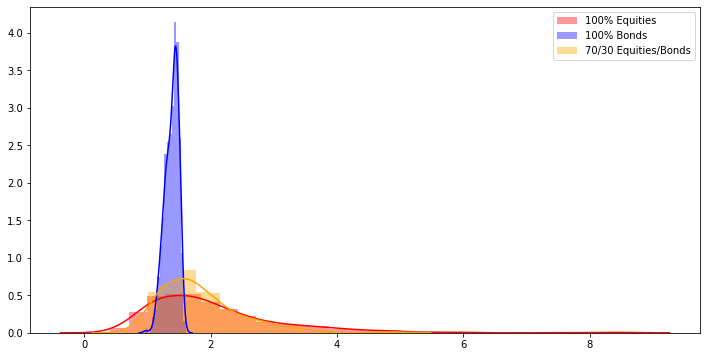

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend()

## Glide Paths for Allocaiton

In [278]:
def glidepath_allocation(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a Target-Date-Fund style gradual move from r1 to r2.
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [279]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocation, start_glide=0.8, end_glide=0.2)
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30"),
    erk.terminal_stats(rets_g8020, name="Glide 80 to 20")
], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.383899,2.027352,1.814814,1.683824
std,0.106718,1.076321,0.643861,0.441710
p_breach,NaN,0.036000,0.010000,0.004000
e_short,NaN,0.131884,0.082316,0.089517
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


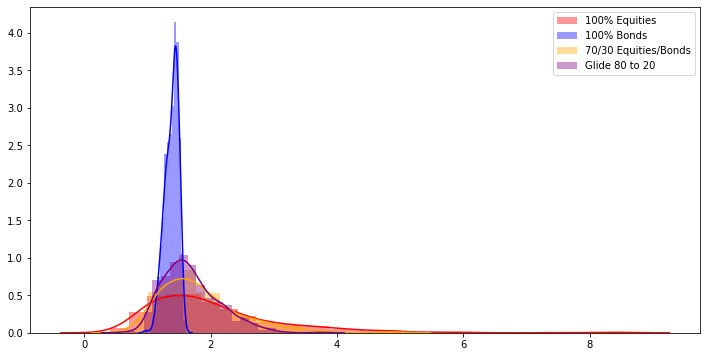

In [280]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
sns.distplot(erk.terminal_values(rets_g8020), color="purple", label="Glide 80 to 20")
plt.legend()

# Liability-Friendly Equity Portfolios
Would it make sense for an investor (e.g. a pension fund) to hold a customized equity portfolio engineered to exhibit enhanced liability-hedging properties versus holding a broad equity index?

## Defining liability friendliness
#### Intuitive approach based on a cash-flow matching focus
- Stocks with high and stable dividends yields should be more attractive than average for liability-matching purposes

#### Statistical approach based on a factor matching focus
- Liabilities are just like zero-coupon bonds, therefore we could find bond-like stocks: stocks with low volativity should be more attractive than average for liability-hedging purposes. This low volativity can be in dividends or in stock value growth.

## Conclusion:
- Selecting stocks with above average liability friendliness allows investors to allocate more to equity for a given risk budget
- This translates into superior performance unless liability friendly stocks strongly underperform the market average

# Dynamics Risk Budgeting between PSP and LHP

In [2]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [3]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, vol=0.02)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [281]:
"""We use zero coupon bond in this simulation as a proxy for duration matched portfolio, 
because a similar portfolio can be constructed with normal bonds as well"""
"""The fixed mix allocator does not take floor into account"""

rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([erk.terminal_stats(rets_eq, floor=0.75, name="EQ"),
          erk.terminal_stats(rets_zc, floor=0.75, name="ZC"),
          erk.terminal_stats(rets_7030b, floor=0.75, name="70/30")],
         axis=1).round(2)

,EQ,ZC,70/30
mean,2.03,1.33,1.79
std,1.08,0.00,0.64
p_breach,0.03,NaN,0.01
e_short,0.10,NaN,0.07
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


## Floor allocator

In [282]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple of the cusion in the PSP
    Returns a DataFrame with the same shape as the PSP/GHP representing the weights in the PSP
    The zc_prices are present values of 1 dollar zero coupon bonds
    Therefore as we go closer to the end, the floor_value will converge to floor as zc_prices converge to 1
    As account_value goes closer to the present value of the floor, safe asset GHP will be more allocated.
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## Present value of floor assuming today's rate and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # weights cannot be lower than or higher than 0 and 1
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [284]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
# use zc_prices[1:] because rets_eq.pct_change().dropna() drops the first row
pd.concat([erk.terminal_stats(rets_eq, floor=0.75, name="EQ"),
          erk.terminal_stats(rets_zc, floor=0.75, name="ZC"),
          erk.terminal_stats(rets_7030b, floor=0.75, name="70/30"),
          erk.terminal_stats(rets_floor75, floor=0.75, name="Floor75")],
         axis=1).round(3)

,EQ,ZC,70/30,Floor75
mean,2.027,1.333,1.788,2.000
std,1.076,0.000,0.636,1.083
p_breach,0.030,NaN,0.006,NaN
e_short,0.105,NaN,0.068,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


We see that the floor allocator successfully eliminated probability of breaches! And the returns were better than 70/30 mix, and essentially equal to that of 100% EQ! However this assumes that we rebalance every month, we will have to take in consideration of transaction costs. What if we rebalance less often?

In [7]:
"""We can try to use different multiplier M"""
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=5)
rets_floor75m10 = erk.bt_mix(rets_eq, rets_zc, allocator=floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=10)

pd.concat([erk.terminal_stats(rets_eq, floor=0.75, name="EQ"),
          erk.terminal_stats(rets_zc, floor=0.75, name="ZC"),
          erk.terminal_stats(rets_7030b, floor=0.75, name="70/30"),
          erk.terminal_stats(rets_floor75, floor=0.75, name="Floor75 M=3"),
          erk.terminal_stats(rets_floor75m1, floor=0.75, name="Floor75 M=1"),
          erk.terminal_stats(rets_floor75m5, floor=0.75, name="Floor75 M=5"),
          erk.terminal_stats(rets_floor75m10, floor=0.75, name="Floor75 M=10")
          ],
          axis=1).round(4)

,EQ,ZC,70/30,Floor75 M=3,Floor75 M=1,Floor75 M=5,Floor75 M=10
mean,1.9925,1.343,1.7703,1.9713,1.6318,1.9804,1.9816
std,1.0000,0.000,0.6054,1.0037,0.4413,1.0069,1.0080
p_breach,0.0394,NaN,0.0104,NaN,NaN,0.0002,0.0248
e_short,0.1297,NaN,0.0708,NaN,NaN,0.0008,0.0045
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that with higher multiplier M, we get some breaches but the probability and expected short are very small. However, there is a point of diminishing returns because M=3 already gives return close to 100% EQ with no breaches.

## Risk Budgeting with Drawdown Constraints

In [289]:
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple of the cusion in the PSP
    Returns a DataFrame with the same shape as the PSP/GHP representing the weights in the PSP
    """
    if ghp_r.shape != psp_r.shape:
        raise ValueError("PSP and GHP returns must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = (1 - maxdd)*peak_value ### Floor is based on prev peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # weights cannot be lower than or higher than 0 and 1
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value and prev peak at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        peak_value = np.maximum(peak_value, account_value)
        w_history.iloc[step] = psp_w
    return w_history

In [299]:
rets_maxdd25 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.drawdown_allocator, maxdd=0.25)

rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
# use zc_prices[1:] because rets_eq.pct_change().dropna() drops the first row
pd.concat([erk.terminal_stats(rets_eq, floor=0.75, name="EQ"),
          erk.terminal_stats(rets_zc, floor=0.75, name="ZC"),
          erk.terminal_stats(rets_7030b, floor=0.75, name="70/30"),
          erk.terminal_stats(rets_floor75, floor=0.75, name="Floor75"),
          erk.terminal_stats(rets_maxdd25, floor=0.75, name="MaxDD25")],
         axis=1).round(3)

,EQ,ZC,70/30,Floor75,MaxDD25
mean,2.027,1.333,1.788,2.000,1.731
std,1.076,0.000,0.636,1.083,0.604
p_breach,0.030,NaN,0.006,NaN,NaN
e_short,0.105,NaN,0.068,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


The point of using the max drawdown was not to avoid breachs, bust instead to have a different goal. From below, we see that the max drawdown in those 5000 scenarios is 0.27, given maxdd=0.25, we did pretty good.

In [306]:
erk.summary_stats(rets_maxdd25)['Max Drawdown'].min()

-0.27372627963696605

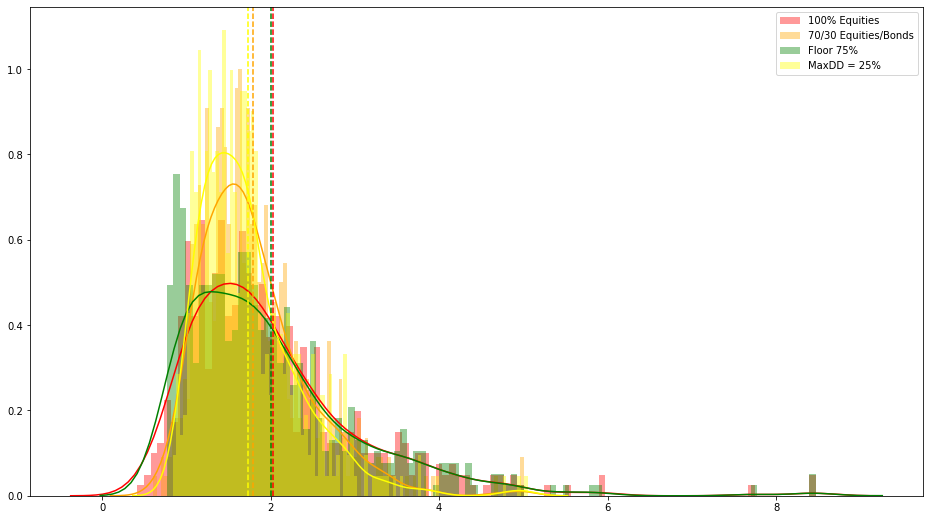

In [307]:
tv_eq = (1+rets_eq).prod()
tv_7030b = (1+rets_7030b).prod()
tv_floor75 = (1+rets_floor75).prod()
tv_maxdd25 = (1+rets_maxdd25).prod()

plt.figure(figsize=(16,9))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
sns.distplot(tv_floor75, color="green", label="Floor 75%", bins=100)
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
plt.axvline(tv_floor75.mean(), ls="--", color="green")
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend()
plt.show()

Therefore we see that dynamic risk budgeting can eliminate breaches compared to 100% equities, while also enjoying the upside potential.

# Drawdown Constraint with Historical Data

In [308]:
ind30_size = pd.read_csv("data/ind30_m_size.csv", index_col=0)
ind30_nfirms = pd.read_csv("data/ind30_m_nfirms.csv", index_col=0)
ind30_rets = pd.read_csv("data/ind30_m_vw_rets.csv", index_col=0)/100

ind30_mcap = ind30_size * ind30_nfirms
ind30_weights = ind30_mcap.div(ind30_mcap.sum(axis=1), axis=0)
rets_tmi = ind30_weights.multiply(ind30_rets, axis=1).sum(axis=1)
rets_tmi.index = pd.to_datetime(rets_tmi.index, format="%Y%m").to_period("M")
rets_tmi = rets_tmi["1990":]

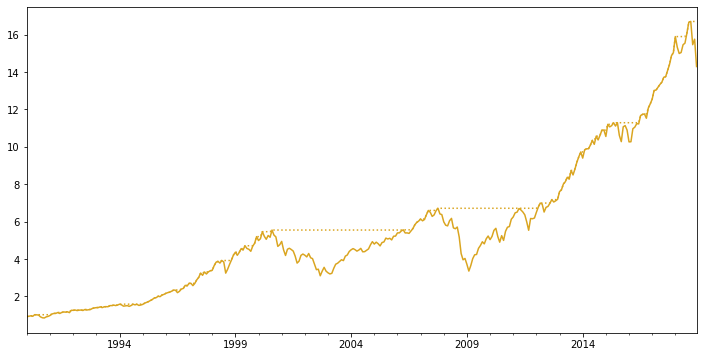

In [309]:
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth index"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous peaks"].plot(ax=ax, ls=":", color="goldenrod")
plt.show()

In [313]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0])
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

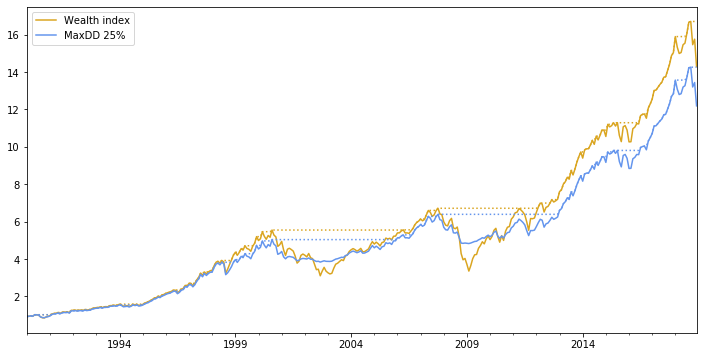

In [311]:
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth index"].plot(figsize=(12,6), ls="-", color="goldenrod", legend=True)
dd_tmi["Previous peaks"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth index"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous peaks"].plot(ax=ax, color="cornflowerblue", ls=":")
plt.show()

In [46]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
